# Poker Hand Data Set 

### Relevant Information:

Each record is an example of a hand consisting of five playing
cards drawn from a standard deck of 52. Each card is described
using two attributes (suit and rank), for a total of 10 predictive
attributes. There is one Class attribute that describes the
�Poker Hand�. The order of cards is important, which is why there
are 480 possible Royal Flush hands as compared to 4 (one for each
suit � explained in more detail below).

### Statistics:


|                  |            |               |                  |
| -                | -          | -             | -                |
| Poker Hand       | # of hands	| Probability	| # of combinations|
| Royal Flush      | 4		    | 0.00000154	| 480              |
| Straight Flush   | 36		    | 0.00001385	| 4320             |
| Four of a kind   | 624		| 0.0002401	    | 74880            |
| Full house       | 3744		| 0.00144058	| 449280           |
| Flush            | 5108		| 0.0019654	    | 612960           |
| Straight         | 10200		| 0.00392464	| 1224000          |
| Three of a kind  | 54912		| 0.02112845	| 6589440          |
| Two pairs        | 123552		| 0.04753902	| 14826240         |
| One pair         | 1098240	| 0.42256903	| 31788800         |
| Nothing          | 1302540	| 0.50117739	| 156304800        |
|                  |            |               |                  |
| Total            | 2598960	| 1.0		    | 311875200        |

# Data Analysis

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)

import keras
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dense, LeakyReLU, Embedding, LSTM
from keras.models import Model
from keras.utils import plot_model
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in [0,9,13]:
    si = plt.style.available[i]
    plt.style.use(si)

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = '../data/Poker/poker-hand-training-true.data'
df = pd.read_csv(path, names=['s1', 'c1', 's2', 'c2', 's3', 'c3', 's4', 'c4', 's5', 'c5', 'label'])

In [3]:
df.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,label
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


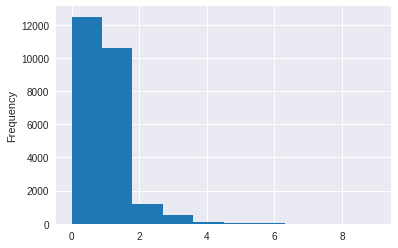

In [4]:
df.label.plot.hist()

# Preprocessing Data

In [5]:
def categorazer(df):
    data = to_categorical(df)
    cat = []
    for si in data:
        sj = [list(si[2*j][:4])+list(si[2*j+1])  for j in range(5)]
        cat.append(sj)
    return np.array(cat)

In [6]:
x_train = categorazer(df[df.columns[:-1]])
y_train = to_categorical(df[df.columns[-1]])
x_train[0], y_train[0]

(array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [7]:
# encode test data
df_test = pd.read_csv('../data/Poker/poker-hand-testing.data')
x_test = categorazer(df_test[df_test.columns[:-1]])
y_test = to_categorical(df_test[df_test.columns[-1]])
x_test[0], y_test[0]

(array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

# MLP Model

In [8]:
n_cards, encodding_size = x_train.shape[1:]
n_cards, encodding_size

(5, 18)

In [13]:
tf.reset_default_graph()
inputs = Input(shape=(n_cards, encodding_size, ))
# a layer instance is callable on a tensor, and returns a tensor
x = Flatten()(inputs)
x = Dense(64)(x)
x = LeakyReLU()(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()
# plot_model(model, to_file='model.png')
# plt.figure(figsize=(10,10))
# img=mpimg.imread('model.png')
# imgplot = plt.imshow(img)
# plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 18)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5824      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

In [17]:

history = model.fit(x_train, y_train,
                    validation_data=(x_test,y_test),
                    epochs=10, 
                    batch_size=32,)  # starts training

Train on 25010 samples, validate on 999999 samples
Epoch 1/10
25010/25010 [==============================] - 14s 544us/step - loss: 0.9807 - acc: 0.5096 - val_loss: 0.9646 - val_acc: 0.5363
Epoch 2/10
25010/25010 [==============================] - 14s 543us/step - loss: 0.9271 - acc: 0.5737 - val_loss: 0.8781 - val_acc: 0.6130
Epoch 3/10
25010/25010 [==============================] - 14s 542us/step - loss: 0.7409 - acc: 0.6911 - val_loss: 0.6354 - val_acc: 0.7488
Epoch 4/10
25010/25010 [==============================] - 14s 542us/step - loss: 0.4768 - acc: 0.8240 - val_loss: 0.3967 - val_acc: 0.8554
Epoch 5/10
25010/25010 [==============================] - 14s 541us/step - loss: 0.2605 - acc: 0.9153 - val_loss: 0.2080 - val_acc: 0.9313
Epoch 6/10
25010/25010 [==============================] - 14s 541us/step - loss: 0.1312 - acc: 0.9642 - val_loss: 0.1209 - val_acc: 0.9677
Epoch 7/10
25010/25010 [==============================] - 14s 543us/step - loss: 0.0932 - acc: 0.9754 - val_loss: 0

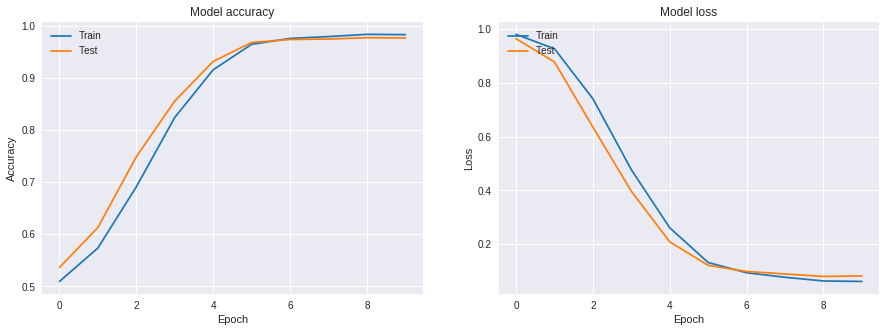

In [18]:
plt.figure(figsize=(15,5))


# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## Validation

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
y_pred = model.predict(x_test)
y_pred, y_test

(array([[3.4929672e-09, 9.4027793e-01, 5.9693135e-02, ..., 3.8167197e-10,
         2.5473535e-05, 2.2316520e-09],
        [1.0701515e-04, 9.9965465e-01, 1.8352317e-04, ..., 2.0754711e-15,
         2.3408309e-05, 1.1113177e-08],
        [6.6476027e-03, 9.9297839e-01, 2.1224016e-06, ..., 5.7741363e-19,
         4.3004427e-05, 5.6859790e-07],
        ...,
        [3.7091697e-05, 9.9988997e-01, 9.0895819e-06, ..., 8.9261647e-18,
         5.2543819e-05, 5.3691938e-08],
        [2.5028830e-06, 9.9980193e-01, 1.1468754e-04, ..., 1.3333431e-15,
         8.0105972e-05, 1.4159204e-07],
        [9.8515484e-19, 1.5815540e-04, 8.8381302e-01, ..., 2.1813863e-05,
         3.8342116e-12, 3.2064690e-17]], dtype=float32),
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]], dtype=float32))

In [21]:
matrix = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
matrix

,0,1,2,3,4,5,6,7,8,9
0,498548,2460,0,0,194,0,0,0,0,6
1,1510,417871,3093,0,24,0,0,0,0,0
2,0,4009,41942,1671,0,0,0,0,0,0
3,0,1,4239,16849,0,0,32,0,0,0
4,3217,58,0,0,538,0,0,0,0,72
5,1989,7,0,0,0,0,0,0,0,0
6,0,0,2,991,0,0,427,4,0,0
7,0,0,0,36,0,0,194,0,0,0
8,9,0,0,0,3,0,0,0,0,0
9,1,0,0,0,1,0,0,0,0,1


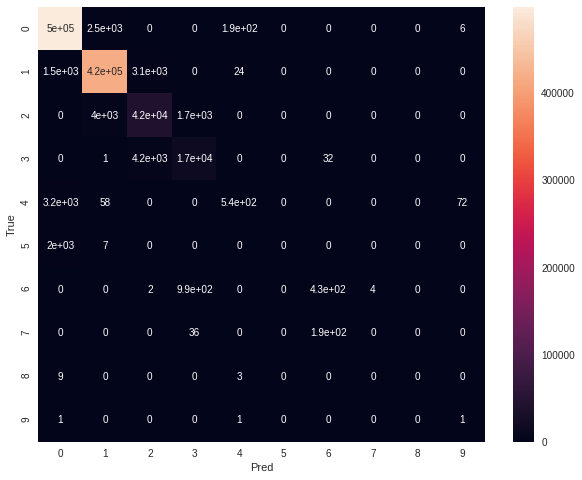

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(matrix,  annot=True)
plt.ylabel('True')
plt.xlabel('Pred');